# Combined MERSCOPE ROI Differential Gene Expression Analysis

This script performs DGE analysis between corresponding ROIs from two different samples:
- Sample 1: p0, Region R4
- Sample 2: p30, Region R3

Comparisons:
- ROI1 (first identified ROI in Sample 1) vs. ROI1 (first identified ROI in Sample 2)
- ROI2 (second identified ROI in Sample 1) vs. ROI2 (second identified ROI in Sample 2)

In [47]:
# Import necessary libraries
import sys
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from shapely import wkt

# Add the project root to the Python path
# script_dir = os.path.dirname(__file__)
script_dir = "E:/Githubs/SPATIAL_data"
project_root = os.path.abspath(script_dir) # If script is in root, project_root is script_dir
sys.path.append(project_root)

from helpers.plotting import create_volcano_plot

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning) # For sjoin warnings if CRS is not set

# Global plot settings
PLOT_INTERMEDIATE_ROI_VISUALIZATIONS = True # Set to True to see ROI plots during data loading
PLOT_FINAL_DGE_VOLCANO = True

## Helper Function: Load and Process Sample Data

In [48]:
def load_sample_data(base_path, h5ad_filename, cell_boundaries_filename, roi_csv_filename, 
                     sample_prefix, target_roi_labels=['ROI1', 'ROI2'], min_gene_expression_per_cell=25):
    """
    Loads and processes data for a single MERSCOPE sample.
    - Loads h5ad, cell boundaries, and ROI geometry.
    - Filters genes and cells.
    - Identifies cells within the first two specified ROIs.
    - Assigns sample-specific ROI labels (e.g., 'sample_prefix_ROI1').
    - Returns an AnnData object with cells from these ROIs and updated .obs.
    """
    print(f"\n--- Processing sample: {sample_prefix} ---")
    h5ad_file_path = os.path.join(base_path, h5ad_filename)
    cell_boundaries_file_path = os.path.join(base_path, cell_boundaries_filename)
    roi_geometry_file_path = os.path.join(base_path, roi_csv_filename)

    # 1. Load AnnData
    print(f"Loading AnnData: {h5ad_file_path}")
    adata = sc.read_h5ad(h5ad_file_path)
    print(f"Initial adata shape: {adata.shape}")

    # 2. Filter genes (remove Blanks)
    genes_before_blank_filter = adata.shape[1]
    keep_genes = [x for x in adata.var.index.tolist() if 'Blank' not in x]
    adata = adata[:, keep_genes].copy()
    print(f"Filtered out 'Blank' genes. Kept {len(keep_genes)} out of {genes_before_blank_filter} genes. New shape: {adata.shape}")

    # 3. Filter cells by minimum total gene expression
    cells_before_min_expr_filter = adata.shape[0]
    ser_exp = adata.to_df().sum(axis=1)
    keep_cells = ser_exp[ser_exp >= min_gene_expression_per_cell].index.tolist()
    adata = adata[keep_cells, :].copy()
    print(f"Filtered cells by min expression ({min_gene_expression_per_cell}). Kept {len(keep_cells)} out of {cells_before_min_expr_filter} cells. New shape: {adata.shape}")

    if adata.shape[0] == 0 or adata.shape[1] == 0:
        print(f"Warning: AnnData for {sample_prefix} is empty after initial filtering. Skipping further processing for this sample.")
        return None

    # 3.5 Normalize and Log-transform data
    print(f"Normalizing total counts per cell to 1e4 and log-transforming data for {sample_prefix}...")
    # Check if data has already been log-transformed by looking at adata.uns
    if not adata.uns.get('log1p', False):
        print(f"Applying sc.pp.normalize_total (target_sum=1e4) and sc.pp.log1p for {sample_prefix}...")
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata) # This will set adata.uns['log1p'] = {'base': None} or similar
        print("Per-sample normalization and log-transformation complete.")
    else:
        print(f"Data for {sample_prefix} appears to be already log-transformed (adata.uns['log1p'] found). Skipping per-sample sc.pp.normalize_total and sc.pp.log1p.")


    # 4. Load cell boundaries
    print(f"Loading cell boundaries: {cell_boundaries_file_path}")
    cell_boundaries_gdf = gpd.read_parquet(cell_boundaries_file_path)
    cell_boundaries_gdf = cell_boundaries_gdf.set_index('EntityID', drop=False)
    # Ensure the index is string type to match downstream operations
    cell_boundaries_gdf.index = cell_boundaries_gdf.index.astype(str)
    print(f"Loaded cell boundaries. Shape: {cell_boundaries_gdf.shape}, Index type: {cell_boundaries_gdf.index.dtype}")

    # 5. Load and process ROI geometries
    print(f"Loading ROI geometry: {roi_geometry_file_path}")
    roi_polygons_df = pd.read_csv(roi_geometry_file_path)
    roi_polygons_df['geometry'] = roi_polygons_df['geometry'].apply(wkt.loads)
    
    current_crs = cell_boundaries_gdf.crs # Use CRS from cell boundaries if available
    roi_gdf = gpd.GeoDataFrame(roi_polygons_df, geometry='geometry', crs=current_crs)
    print(f"Loaded and converted ROI geometries. Shape: {roi_gdf.shape}")

    # 6. Spatially select cells within ROIs
    cell_boundaries_gdf_sjoin_ready = cell_boundaries_gdf.copy()
    cell_boundaries_gdf_sjoin_ready.index.name = 'original_cell_EntityID_idx'
    
    cells_in_rois_gdf = gpd.sjoin(
        cell_boundaries_gdf_sjoin_ready,
        roi_gdf,
        how="inner",
        predicate="within",
        lsuffix='_cell',
        rsuffix='_roi'
    )
    print(f"Found {cells_in_rois_gdf.shape[0]} cells within any defined ROIs.")
    
    if cells_in_rois_gdf.empty:
        print(f"Warning: No cells found within any ROIs for {sample_prefix}. Skipping ROI assignment.")
        return None

    # 7. Assign sample-specific ROI labels (e.g., 'p0_R4_ROI1')
    # We use the first two unique groups found in the 'group' column of the ROI CSV.
    roi_group_column_in_csv = 'group' # This is 'group' in the provided examples
    available_roi_groups_from_csv = cells_in_rois_gdf[roi_group_column_in_csv].unique()
    
    adata.obs['roi_assignment'] = 'unassigned' # This will be the common column for concatenated adata
    
    # Map original cell EntityIDs (from cells_in_rois_gdf) to new prefixed ROI labels
    # Ensure EntityIDs are strings for consistent mapping with adata.obs.index
    cells_in_rois_gdf.index = cells_in_rois_gdf.index.astype(str)
    adata.obs.index = adata.obs.index.astype(str)

    assigned_count = 0
    if len(available_roi_groups_from_csv) >= 1:
        roi1_original_name_in_csv = available_roi_groups_from_csv[0]
        new_label_roi1 = f"{sample_prefix}_{target_roi_labels[0]}"
        print(f"Mapping CSV group '{roi1_original_name_in_csv}' to '{new_label_roi1}'")
        cells_for_this_roi = cells_in_rois_gdf[cells_in_rois_gdf[roi_group_column_in_csv] == roi1_original_name_in_csv].index
        
        # Intersect with adata.obs.index to only assign to cells present in adata
        valid_cells_for_assignment = adata.obs.index.intersection(cells_for_this_roi)
        adata.obs.loc[valid_cells_for_assignment, 'roi_assignment'] = new_label_roi1
        assigned_count += len(valid_cells_for_assignment)
        print(f"Assigned {len(valid_cells_for_assignment)} cells to {new_label_roi1}")

    if len(available_roi_groups_from_csv) >= 2 and len(target_roi_labels) >=2:
        roi2_original_name_in_csv = available_roi_groups_from_csv[1]
        new_label_roi2 = f"{sample_prefix}_{target_roi_labels[1]}"
        print(f"Mapping CSV group '{roi2_original_name_in_csv}' to '{new_label_roi2}'")
        cells_for_this_roi = cells_in_rois_gdf[cells_in_rois_gdf[roi_group_column_in_csv] == roi2_original_name_in_csv].index
        
        valid_cells_for_assignment = adata.obs.index.intersection(cells_for_this_roi)
        adata.obs.loc[valid_cells_for_assignment, 'roi_assignment'] = new_label_roi2
        assigned_count += len(valid_cells_for_assignment)
        print(f"Assigned {len(valid_cells_for_assignment)} cells to {new_label_roi2}")
    else:
        print(f"Warning: Fewer than 2 ROI groups found in CSV for {sample_prefix} or fewer than 2 target labels. Only ROI1 might be processed.")

    print(f"Total cells assigned to target ROIs in adata.obs for {sample_prefix}: {assigned_count}")
    print(f"Value counts for 'roi_assignment' in {sample_prefix}:\n{adata.obs['roi_assignment'].value_counts()}")

    # 8. Filter AnnData to keep only cells assigned to the target ROIs
    target_labels_for_sample = []
    if len(target_roi_labels) >= 1: target_labels_for_sample.append(f"{sample_prefix}_{target_roi_labels[0]}")
    if len(target_roi_labels) >= 2: target_labels_for_sample.append(f"{sample_prefix}_{target_roi_labels[1]}")
    
    adata_filtered_rois = adata[adata.obs['roi_assignment'].isin(target_labels_for_sample)].copy()
    print(f"Shape of AnnData for {sample_prefix} after filtering for target ROIs: {adata_filtered_rois.shape}")

    if PLOT_INTERMEDIATE_ROI_VISUALIZATIONS and (adata_filtered_rois.shape[0] > 0) and not cells_in_rois_gdf.empty:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        # Plot all original cell boundaries lightly
        cell_boundaries_gdf.plot(ax=ax, color='lightgray', edgecolor='silver', alpha=0.3, label='All Cells (Original)')
        
        # Plot cells within any ROI, colored by their original CSV group
        # Need to merge 'group' from cells_in_rois_gdf to cell_boundaries_gdf for plotting all selected cells
        unique_cell_ids_in_rois = cells_in_rois_gdf.index.unique()
        temp_plot_gdf = cell_boundaries_gdf.loc[unique_cell_ids_in_rois] # Get geometries of cells in any ROI

        # Define the actual column name for ROI group after sjoin
        # roi_group_column_in_csv is 'group' (defined earlier at line 130), rsuffix for sjoin (line 120) was '_roi'
        # The ROI group column in cells_in_rois_gdf is roi_group_column_in_csv (e.g., 'group'),
        # as established by successful access on line 130.
        # No suffix is added if cell_boundaries_gdf (left df) doesn't have a 'group' column.

        # Prepare data for merging: we need the index (EntityID) and the ROI group column.
        # cells_in_rois_gdf.index contains EntityIDs (and its .name is 'original_cell_EntityID_idx').
        # Reset index of cells_in_rois_gdf to make 'original_cell_EntityID_idx' a column.
        # cells_in_rois_gdf.index.name is 'original_cell_EntityID_idx' (set on line 111).
        cells_in_rois_gdf_for_merge = cells_in_rois_gdf.reset_index()

        # Now 'original_cell_EntityID_idx' is a regular column in cells_in_rois_gdf_for_merge.
        # Select this column and the ROI group column to create the merge_helper_df.
        merge_helper_df = cells_in_rois_gdf_for_merge[
            ['original_cell_EntityID_idx', roi_group_column_in_csv]
        ].drop_duplicates(subset=['original_cell_EntityID_idx']) # Ensure one group per cell for merging

        temp_plot_gdf = temp_plot_gdf.merge(
            merge_helper_df,
            left_index=True, # temp_plot_gdf is indexed by EntityID
            right_on='original_cell_EntityID_idx', # merge_helper_df has EntityIDs in this column
            how='left'
        )

        # Use roi_group_column_in_csv for plotting, as this is the correct column name in cells_in_rois_gdf
        # and subsequently in temp_plot_gdf after the merge.
        temp_plot_gdf.plot(ax=ax, column=roi_group_column_in_csv, legend=True, alpha=0.7, categorical=True,
                           legend_kwds={'title': f"{sample_prefix} CSV ROI Group ({roi_group_column_in_csv})", 'loc': 'upper right', 'bbox_to_anchor': (1.45, 1)})
        roi_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='ROI Polygons (from CSV)')
        ax.set_title(f"Cells within Defined ROIs for {sample_prefix}")
        plt.tight_layout(rect=[0, 0, 0.80, 1])
        plt.show()

    return adata_filtered_rois

## 1. Define File Paths and Parameters

In [49]:
# Sample 1 (p0/R4)
base_path_s1 = './202504111150_Sessa-p0-p7_VMSC10702/R4' # Adjusted path relative to project root
h5ad_filename_s1 = '202504111150_Sessa-p0-p7_VMSC10702_region_R4.h5ad'
roi_csv_filename_s1 = 'p0_R4_ROI_28-05-25_17-01_geometry.csv'
sample_prefix_s1 = 'p0_R4'

# Sample 2 (p30/R3)
base_path_s2 = './202503071102_SESSA-p30-E165_VMSC10702/R3' # Adjusted path relative to project root
h5ad_filename_s2 = '202503071102_SESSA-p30-E165_VMSC10702_region_R3.h5ad'
roi_csv_filename_s2 = 'p30_R3_ROI_28-05-25_16-57_geometry.csv'
sample_prefix_s2 = 'p30_R3'

# Common parameters
cell_boundaries_filename_common = 'cell_boundaries.parquet'
target_roi_names = ['ROI1', 'ROI2'] # Generic names we assign to the first two ROIs found in each sample

# DGE Parameters
pval_threshold = 0.05
logfc_threshold = 0.5
top_genes_to_show = 10

## 2. Load Data for Both Samples


--- Processing sample: p0_R4 ---
Loading AnnData: ./202504111150_Sessa-p0-p7_VMSC10702/R4\202504111150_Sessa-p0-p7_VMSC10702_region_R4.h5ad
Initial adata shape: (44424, 960)
Filtered out 'Blank' genes. Kept 960 out of 960 genes. New shape: (44424, 960)
Filtered cells by min expression (25). Kept 44387 out of 44424 cells. New shape: (44387, 960)
Normalizing total counts per cell to 1e4 and log-transforming data for p0_R4...
Applying sc.pp.normalize_total (target_sum=1e4) and sc.pp.log1p for p0_R4...
Per-sample normalization and log-transformation complete.
Loading cell boundaries: ./202504111150_Sessa-p0-p7_VMSC10702/R4\cell_boundaries.parquet
Loaded cell boundaries. Shape: (320852, 9), Index type: object
Loading ROI geometry: ./202504111150_Sessa-p0-p7_VMSC10702/R4\p0_R4_ROI_28-05-25_17-01_geometry.csv
Loaded and converted ROI geometries. Shape: (2, 4)
Found 75271 cells within any defined ROIs.
Mapping CSV group 'SubROI cortex' to 'p0_R4_ROI1'
Assigned 2402 cells to p0_R4_ROI1
Mapping

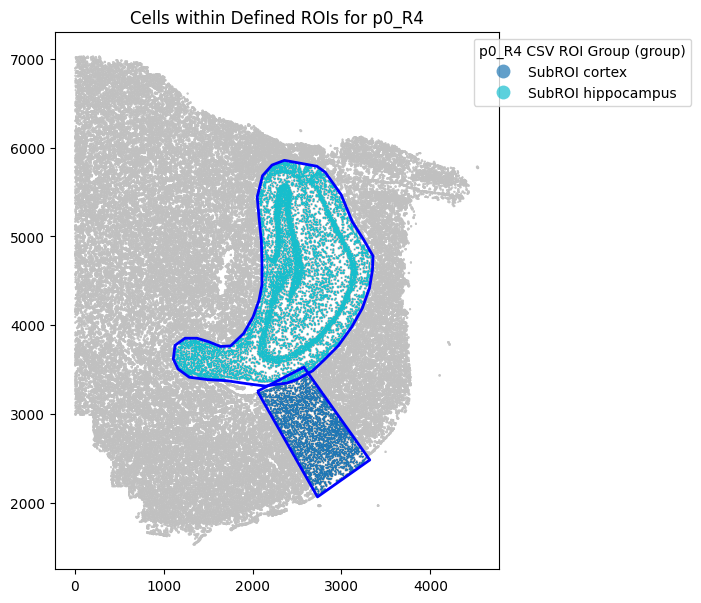

In [50]:
adata_s1 = load_sample_data(
    base_path=base_path_s1,
    h5ad_filename=h5ad_filename_s1,
    cell_boundaries_filename=cell_boundaries_filename_common,
    roi_csv_filename=roi_csv_filename_s1,
    sample_prefix=sample_prefix_s1,
    target_roi_labels=target_roi_names
)


--- Processing sample: p30_R3 ---
Loading AnnData: ./202503071102_SESSA-p30-E165_VMSC10702/R3\202503071102_SESSA-p30-E165_VMSC10702_region_R3.h5ad
Initial adata shape: (43284, 960)
Filtered out 'Blank' genes. Kept 960 out of 960 genes. New shape: (43284, 960)
Filtered cells by min expression (25). Kept 43283 out of 43284 cells. New shape: (43283, 960)
Normalizing total counts per cell to 1e4 and log-transforming data for p30_R3...
Applying sc.pp.normalize_total (target_sum=1e4) and sc.pp.log1p for p30_R3...
Per-sample normalization and log-transformation complete.
Loading cell boundaries: ./202503071102_SESSA-p30-E165_VMSC10702/R3\cell_boundaries.parquet
Loaded cell boundaries. Shape: (308336, 9), Index type: object
Loading ROI geometry: ./202503071102_SESSA-p30-E165_VMSC10702/R3\p30_R3_ROI_28-05-25_16-57_geometry.csv
Loaded and converted ROI geometries. Shape: (2, 4)
Found 43911 cells within any defined ROIs.
Mapping CSV group 'SubROI cortex' to 'p30_R3_ROI1'
Assigned 2169 cells to p

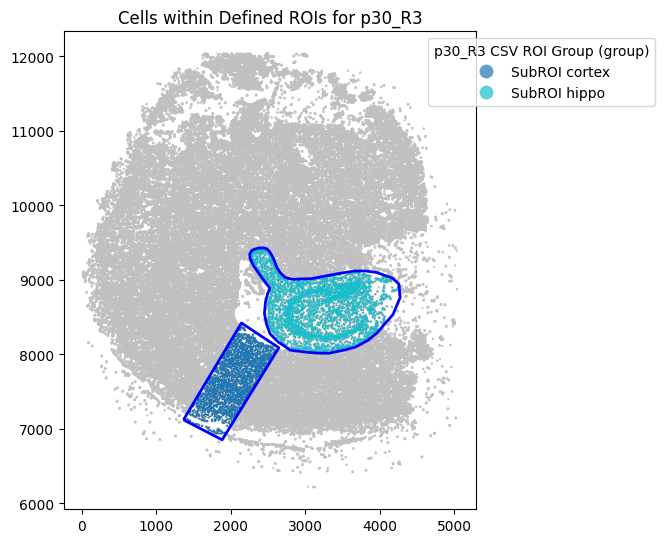

In [51]:
adata_s2 = load_sample_data(
    base_path=base_path_s2,
    h5ad_filename=h5ad_filename_s2,
    cell_boundaries_filename=cell_boundaries_filename_common,
    roi_csv_filename=roi_csv_filename_s2,
    sample_prefix=sample_prefix_s2,
    target_roi_labels=target_roi_names
)

## 3. Combine AnnData Objects

In [52]:
if adata_s1 is not None and not adata_s1.obs.empty and \
   adata_s2 is not None and not adata_s2.obs.empty:
    
    print(f"adata_s1 shape before concat: {adata_s1.shape}, obs keys: {adata_s1.obs.columns.tolist()}")
    print(f"adata_s1 roi_assignment example: {adata_s1.obs['roi_assignment'].unique()[:5]}")
    print(f"adata_s2 shape before concat: {adata_s2.shape}, obs keys: {adata_s2.obs.columns.tolist()}")
    print(f"adata_s2 roi_assignment example: {adata_s2.obs['roi_assignment'].unique()[:5]}")

    # Ensure var_names (genes) are identical or handle appropriately (e.g., intersection)
    # For now, assuming 'join="inner"' handles gene differences by taking intersection.
    adata_combined = ad.concat(
        {"s1": adata_s1, "s2": adata_s2},
        label="sample_batch_id",  # Adds 's1' or 's2' to obs
        join="inner",        # Keeps only common genes
        index_unique="-"     # Appends batch key to make cell indices unique if needed
    )
    print(f"Combined AnnData shape: {adata_combined.shape}")
    print(f"Combined AnnData .obs columns: {adata_combined.obs.columns}")
    print(f"Value counts for 'roi_assignment' in combined data:\n{adata_combined.obs['roi_assignment'].value_counts()}")
    print(f"Value counts for 'sample_batch_id' in combined data:\n{adata_combined.obs['sample_batch_id'].value_counts()}")

    # 3.1 Create a generic ROI type for ComBat covariate to avoid perfect confounding
    if adata_combined is not None:
        adata_combined.obs['generic_roi_type'] = adata_combined.obs['roi_assignment'].apply(
            lambda x: x.split('_')[-1] if isinstance(x, str) else 'Unknown'
        )
        print(f"Created 'generic_roi_type' for ComBat covariates:\n{adata_combined.obs['generic_roi_type'].value_counts()}")
        if not isinstance(adata_combined.obs['generic_roi_type'].dtype, pd.CategoricalDtype):
            adata_combined.obs['generic_roi_type'] = adata_combined.obs['generic_roi_type'].astype('category')

    # 3.2 Filter low-variance genes before ComBat
    if adata_combined is not None:
        print(f"Shape before filtering low-variance genes: {adata_combined.shape}")
        # More stringent gene filtering
        print("Applying gene filtering: min_counts=5, then min_cells=20")
        sc.pp.filter_genes(adata_combined, min_counts=5)
        sc.pp.filter_genes(adata_combined, min_cells=20)
        print(f"Shape after filtering low-variance genes: {adata_combined.shape}")

    # 3.5 Batch Correction using ComBat
    # Note: This requires the 'pycombat' package or similar to be installed (e.g., pip install pycombat)
    # ComBat expects log-transformed data. Our per-sample processing should ensure this.
    if adata_combined is not None and 'sample_batch_id' in adata_combined.obs and 'generic_roi_type' in adata_combined.obs:
        print("\nApplying ComBat for batch correction across 'sample_batch_id' preserving 'generic_roi_type'...")
        try:
            # Ensure 'sample_batch_id' is categorical for ComBat
            if not isinstance(adata_combined.obs['sample_batch_id'].dtype, pd.CategoricalDtype):
                adata_combined.obs['sample_batch_id'] = adata_combined.obs['sample_batch_id'].astype('category')
            
            # Ensure 'generic_roi_type' (covariate) is categorical
            if not isinstance(adata_combined.obs['generic_roi_type'].dtype, pd.CategoricalDtype):
                 adata_combined.obs['generic_roi_type'] = adata_combined.obs['generic_roi_type'].astype('category')

            print("Attempting batch correction using sc.pp.combat...")
            sc.pp.combat(adata_combined, key='sample_batch_id', covariates=['generic_roi_type']) # inplace=True by default
            print("Scanpy ComBat batch correction (sc.pp.combat) with 'generic_roi_type' as covariate complete. adata_combined.X has been updated.")

            # After ComBat, check for non-positive values and shift if necessary
            if adata_combined.X is not None:
                min_val = adata_combined.X.min()
                if min_val <= 0:
                    print(f"ComBat output contains non-positive values (min: {min_val}). Shifting data to be strictly positive.")
                    # Convert to dense if sparse, perform operation, then potentially convert back if memory is an issue
                    # For now, assume direct operation is fine.
                    if hasattr(adata_combined.X, "toarray"): # Check if sparse
                        adata_combined.X = adata_combined.X.toarray() - min_val + 0.0001
                    else:
                        adata_combined.X = adata_combined.X - min_val + 0.0001
                    print(f"Data shifted. New min value: {adata_combined.X.min()}")
        except AttributeError as attr_err:
            print(f"AttributeError during sc.pp.combat: {attr_err}")
            print("This might mean 'sc.pp.combat' is not available in your Scanpy version, or an underlying issue.")
            print("Ensure your Scanpy version is recent and try installing 'pycombat' and 'patsy': 'pip install pycombat patsy'.")
            print("Proceeding with DGE on non-batch-corrected combined data.")
            
        except ImportError as imp_err: # Catches import errors for dependencies of sc.pp.combat (like pycombat or patsy)
            print(f"ImportError during ComBat setup or execution: {imp_err}")
            print("This often means a required package (like 'pycombat' or 'patsy') for sc.pp.combat is missing.")
            print("Please try installing them: 'pip install pycombat patsy'.")
            print("Proceeding with DGE on non-batch-corrected combined data.")
            
        except Exception as e_combat: # Catch any other unexpected errors from sc.pp.combat
            print(f"An unexpected error occurred during sc.pp.combat: {e_combat}")
            print("Proceeding with DGE on non-batch-corrected combined data.")
    else:
        print("Skipping ComBat batch correction as combined data is not available or 'sample_batch_id' is missing.")

else:
    print("One or both AnnData objects are None or empty after processing. Cannot proceed with combined analysis.")
    adata_combined = None

adata_s1 shape before concat: (10521, 960), obs keys: ['volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden', 'roi_assignment']
adata_s1 roi_assignment example: ['p0_R4_ROI1' 'p0_R4_ROI2']
adata_s2 shape before concat: (6230, 960), obs keys: ['volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden', 'roi_assignment']
adata_s2 roi_assignment example: ['p30_R3_ROI1' 'p30_R3_ROI2']
Combined AnnData shape: (16751, 960)
Combined AnnData .obs columns: Index(['volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden',
       'roi_assignment', 'sample_batch_id'],
      dtype='object')
Value counts for 'roi_assignment' in combined data:
roi_assignment
p0_R4_ROI2     8226
p30_R3_ROI2    4061
p0_R4_ROI1     2295
p30_R3_ROI1    2169
Name: count, dtype: int64
Value counts for 'sample_batch_id' in combined data:
sample_batch_id
s1    10521
s2     6230
Name: count, dtype: int64
Created 'generic_roi_type' for ComBat covariates:
generic_roi_type
ROI2    12287
ROI1     4464
N

## 4. Differential Gene Expression (DGE) Analysis

In [53]:
def perform_dge_and_visualize(adata_input, group_to_test, reference_group, pval_thresh, logfc_thresh, top_n_genes, plot_flag=True):
    """
    Performs DGE analysis between two groups in an AnnData object and visualizes results.
    """
    if adata_input is None or adata_input.shape[0] < 2 or adata_input.shape[1] == 0: # Min 1 cell per group
        print(f"Skipping DGE for {group_to_test} vs {reference_group} due to insufficient data.")
        return None

    print(f"\n--- DGE: {group_to_test} (test) vs {reference_group} (reference) ---")
    
    # Filter for the two specific groups for this comparison
    adata_for_dge = adata_input[adata_input.obs['roi_assignment'].isin([group_to_test, reference_group])].copy()
    
    if adata_for_dge.obs.groupby('roi_assignment').size().min() < 1: # Check if any group is empty
         print(f"Warning: One of the groups ('{group_to_test}' or '{reference_group}') is empty or has too few cells after filtering for DGE. Skipping.")
         return None
    if len(adata_for_dge.obs['roi_assignment'].unique()) < 2:
        print(f"Warning: Only one group present after filtering for DGE ('{group_to_test}', '{reference_group}'). Skipping comparison.")
        return None


    print(f"Shape of AnnData for this DGE comparison: {adata_for_dge.shape}")
    print(f"Cell counts per group for DGE:\n{adata_for_dge.obs['roi_assignment'].value_counts()}")

    # Data should already be log-transformed from load_sample_data.
    # sc.pp.log1p(adata_for_dge) # REMOVED

    # Perform DGE
    dge_key = f"rank_genes_{group_to_test}_vs_{reference_group}"
    sc.tl.rank_genes_groups(
        adata_for_dge,
        groupby='roi_assignment',
        groups=[group_to_test],      # Group to test (numerator for logFC)
        reference=reference_group,   # Reference group (denominator for logFC)
        method='wilcoxon',
        corr_method='benjamini-hochberg',
        key_added=dge_key,
        use_raw=False # Ensure we use the .X layer (ComBat corrected)
    )
    print("DGE calculation complete.")

    # Visualize DGE results (Volcano Plot)
    if plot_flag:
        print(f"Creating volcano plot for {group_to_test} vs {reference_group}...")
        fig, ax = create_volcano_plot(
            adata_for_dge,
            group_name=group_to_test, # This is the group for which scores, pvals etc. are reported directly
            key=dge_key,
            pval_threshold=pval_thresh,
            logfc_threshold=logfc_thresh,
            title=f"Volcano: {group_to_test} vs {reference_group}",
            show_gene_labels=True,
            top_genes=top_n_genes
        )
        plt.show()

    # Display DGE results as a DataFrame
    try:
        # The results are structured under the name of the group tested (group_to_test)
        dge_results_df = pd.DataFrame(adata_for_dge.uns[dge_key]['names'])[group_to_test]
        dge_scores_df = pd.DataFrame(adata_for_dge.uns[dge_key]['scores'])[group_to_test]
        dge_pvals_df = pd.DataFrame(adata_for_dge.uns[dge_key]['pvals_adj'])[group_to_test]
        dge_logfc_df = pd.DataFrame(adata_for_dge.uns[dge_key]['logfoldchanges'])[group_to_test]

        summary_df = pd.DataFrame({
            'gene': dge_results_df,
            'score': dge_scores_df,
            'pval_adj': dge_pvals_df,
            'log2fc': dge_logfc_df
        })
        print(f"\nTop DEGs for {group_to_test} compared to {reference_group} (log2fc > 0 means higher in {group_to_test}):")
        print(summary_df.head(top_n_genes * 2)) # Show more for inspection
        return summary_df
    except KeyError as e:
        print(f"Error extracting DGE results for {group_to_test}: {e}")
        print(f"Available keys in adata_for_dge.uns['{dge_key}']: {list(adata_for_dge.uns[dge_key].keys())}")
        if 'names' in adata_for_dge.uns[dge_key]:
             print(f"Structure of 'names': {type(adata_for_dge.uns[dge_key]['names'])}")
             if isinstance(adata_for_dge.uns[dge_key]['names'], np.recarray):
                  print(f"Field names in 'names' recarray: {adata_for_dge.uns[dge_key]['names'].dtype.names}")
        return None

### 4.1 DGE: ROI1 (Sample 2 vs Sample 1)

Performing DGE for ROI1: p30_R3_ROI1 (test) vs p0_R4_ROI1 (reference)

--- DGE: p30_R3_ROI1 (test) vs p0_R4_ROI1 (reference) ---
Shape of AnnData for this DGE comparison: (4464, 960)
Cell counts per group for DGE:
roi_assignment
p0_R4_ROI1     2295
p30_R3_ROI1    2169
Name: count, dtype: int64
DGE calculation complete.
Creating volcano plot for p30_R3_ROI1 vs p0_R4_ROI1...
Volcano plot summary for p30_R3_ROI1:
Total genes: 960
Significant genes: 42 (4.4%)
Upregulated: 3
Downregulated: 39


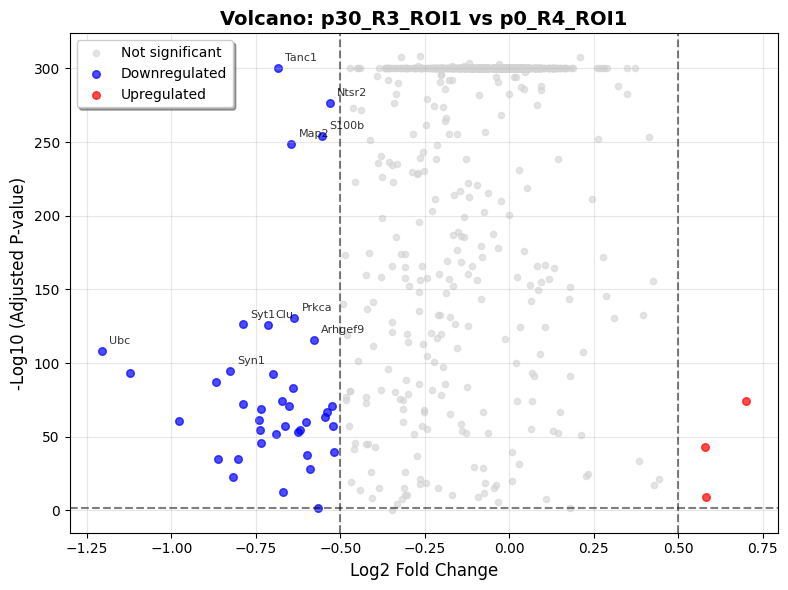


Top DEGs for p30_R3_ROI1 compared to p0_R4_ROI1 (log2fc > 0 means higher in p30_R3_ROI1):
       gene      score       pval_adj    log2fc
0      Prlr  57.434948   0.000000e+00  0.130971
1   Pla2g4d  57.277988   0.000000e+00  0.110556
2      Pax2  56.774002   0.000000e+00  0.149234
3     Cplx3  56.572411   0.000000e+00  0.087724
4     Lrig2  55.739265   0.000000e+00 -0.012225
5     Cdc42  53.178650   0.000000e+00  0.004099
6    Gabra3  52.893311   0.000000e+00  0.279088
7     Ephb6  52.692951   0.000000e+00  0.010993
8      Syt2  52.641319   0.000000e+00  0.372380
9     Cntn6  51.684025   0.000000e+00  0.021989
10    Calb1  50.598911   0.000000e+00 -0.130895
11    Efna5  50.375172   0.000000e+00  0.058241
12    Camk4  50.068344   0.000000e+00 -0.148072
13    Pparg  48.973515   0.000000e+00  0.016041
14    Unc5d  47.189049   0.000000e+00 -0.086815
15    Lamp5  45.744778   0.000000e+00  0.288482
16    Gabrd  45.696003   0.000000e+00  0.118884
17   Homer1  45.614983   0.000000e+00 -0.1776

In [54]:
if adata_combined is not None:
    roi1_s1_label = f"{sample_prefix_s1}_{target_roi_names[0]}" # e.g., p0_R4_ROI1
    roi1_s2_label = f"{sample_prefix_s2}_{target_roi_names[0]}" # e.g., p30_R3_ROI1

    # Check if both ROI1 labels exist in the combined data
    if roi1_s1_label in adata_combined.obs['roi_assignment'].unique() and \
       roi1_s2_label in adata_combined.obs['roi_assignment'].unique():
        
        print(f"Performing DGE for ROI1: {roi1_s2_label} (test) vs {roi1_s1_label} (reference)")
        summary_roi1 = perform_dge_and_visualize(
            adata_input=adata_combined,
            group_to_test=roi1_s2_label,    # Test group
            reference_group=roi1_s1_label,  # Reference group
            pval_thresh=pval_threshold,
            logfc_thresh=logfc_threshold,
            top_n_genes=top_genes_to_show,
            plot_flag=PLOT_FINAL_DGE_VOLCANO
        )
    else:
        print(f"Skipping DGE for ROI1 as one or both required ROI groups ({roi1_s1_label}, {roi1_s2_label}) are not present in the combined data.")
        print(f"Available ROI assignments: {adata_combined.obs['roi_assignment'].unique()}")

### 4.2 DGE: ROI2 (Sample 2 vs Sample 1)

Performing DGE for ROI2: p30_R3_ROI2 (test) vs p0_R4_ROI2 (reference)

--- DGE: p30_R3_ROI2 (test) vs p0_R4_ROI2 (reference) ---
Shape of AnnData for this DGE comparison: (12287, 960)
Cell counts per group for DGE:
roi_assignment
p0_R4_ROI2     8226
p30_R3_ROI2    4061
Name: count, dtype: int64
DGE calculation complete.
Creating volcano plot for p30_R3_ROI2 vs p0_R4_ROI2...
Volcano plot summary for p30_R3_ROI2:
Total genes: 960
Significant genes: 2 (0.2%)
Upregulated: 0
Downregulated: 2


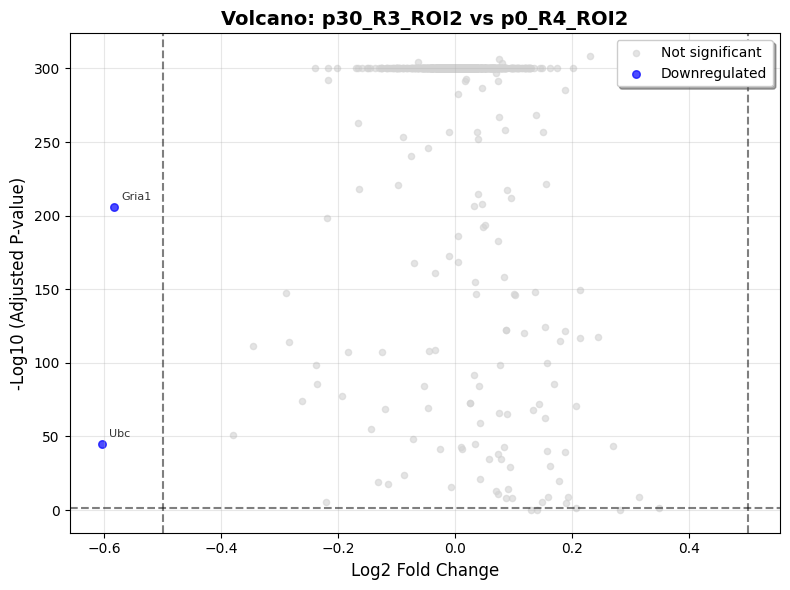


Top DEGs for p30_R3_ROI2 compared to p0_R4_ROI2 (log2fc > 0 means higher in p30_R3_ROI2):
       gene      score      pval_adj    log2fc
0     Camk4  87.176865  0.000000e+00  0.051691
1    Homer1  86.973167  0.000000e+00  0.065815
2     Calb1  85.321815  0.000000e+00  0.036563
3     Cdc42  85.312027  0.000000e+00 -0.019459
4       Ntm  81.760681  0.000000e+00  0.085587
5     Negr1  76.174049  0.000000e+00  0.103036
6    Gabra1  68.254936  0.000000e+00  0.011378
7       Omg  64.591484  0.000000e+00 -0.023437
8     Nrcam  54.617874  0.000000e+00 -0.021666
9     Gnao1   9.563426  1.163460e-21  0.042430
10   Shank1   6.014195  1.828782e-09  0.193327
11   Camk2a   4.253540  2.115189e-05  0.189519
12   Dpysl2   1.827380  6.785469e-02  0.206644
13     Nfix   0.330474  7.418149e-01  0.281764
14  Epb41l1   0.091066  9.274398e-01  0.140431
15    Cplx2  -0.813592  4.167472e-01  0.128770
16   Eef1a2  -2.175215  2.973793e-02  0.348694
17      Src  -4.547712  5.457323e-06  0.148456
18      Mbp  -4.

In [55]:
if adata_combined is not None and len(target_roi_names) >= 2:
    roi2_s1_label = f"{sample_prefix_s1}_{target_roi_names[1]}" # e.g., p0_R4_ROI2
    roi2_s2_label = f"{sample_prefix_s2}_{target_roi_names[1]}" # e.g., p30_R3_ROI2

    # Check if both ROI2 labels exist
    if roi2_s1_label in adata_combined.obs['roi_assignment'].unique() and \
       roi2_s2_label in adata_combined.obs['roi_assignment'].unique():

        print(f"Performing DGE for ROI2: {roi2_s2_label} (test) vs {roi2_s1_label} (reference)")
        summary_roi2 = perform_dge_and_visualize(
            adata_input=adata_combined,
            group_to_test=roi2_s2_label,    # Test group
            reference_group=roi2_s1_label,  # Reference group
            pval_thresh=pval_threshold,
            logfc_thresh=logfc_threshold,
            top_n_genes=top_genes_to_show,
            plot_flag=PLOT_FINAL_DGE_VOLCANO
        )
    else:
        print(f"Skipping DGE for ROI2 as one or both required ROI groups ({roi2_s1_label}, {roi2_s2_label}) are not present in the combined data.")
        print(f"Available ROI assignments: {adata_combined.obs['roi_assignment'].unique()}")
elif adata_combined is not None:
    print("Skipping DGE for ROI2 as only one target ROI name was specified.")

In [56]:
print("\n--- End of Combined DEG Analysis Script ---")


--- End of Combined DEG Analysis Script ---
